<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./2_3_S6_coastal_waveforms.ipynb" target="_blank"><< Coastal waveforms</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./2_5_acquire_S6_available_cycles.ipynb">Acquire a Sentinel-6 track over all available cycles >></a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2024 European Union <br>
**License:** MIT <br>
**Authors:** Vinca Rosmorduc (CLS), Ben Loveday (EUMETSAT/Innoflair UG), Hayley Evers-King (EUMETSAT)

<html>
   <div style="float:left"><p>&emsp;</p></div>
   <div style="float:left"><a href="https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/sensors/learn-s6"><img src="https://img.shields.io/badge/open-EUMETLAB-E67E22.svg"></a></div>
   <div style="float:left"><p>&emsp;</p></div>
   <div style="float:left"><a href="https://user.eumetsat.int/data/themes/marine"><img src="https://img.shields.io/badge/open-USER PORTAL-154360.svg"></a></div>
   <div style="float:left"><p>&emsp;</p></div>
   <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-s6/HEAD?labpath=2_S6_advanced%2F2_4_iono_corr_solarstorms.ipynb"><img src="https://mybinder.org/badge_logo.svg"></a></div>
   <div style="float:left"><p>&emsp;</p></div>
   <div style="float:left"><a href="https://jupyterhub.prod.wekeo2.eu/hub/user-redirect/lab/tree/public/wekeo4oceans/learn-s6/2_S6_advanced/2_4_iono_corr_solarstorms.ipynb"><img src="https://img.shields.io/badge/launch-WEKEO-1a4696.svg"></a></div>
   <div style="float:left"><p>&emsp;</p></div>
   <div style="float:left"><a href="https://code.insula.destine.eu/hub/"><img src="https://img.shields.io/badge/launch-DestinE-f43fd3.svg"></a></div></div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn Sentinel-6: Advanced</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
This notebook has the following prerequisites:
- **<a href="https://eoportal.eumetsat.int/" target="_blank">A EUMETSAT Earth Observation Portal account</a>** to use the EUMETSAT Data Store
    
There are no prerequisite notebooks for this module.
</div>
<hr>

# 2.4 How can a solar storm impact SSH measurement?

### Data used

| Dataset | EUMETSAT collection ID| EUMETSAT collection<br>description | WEkEO dataset ID | WEkEO description |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:--------:|
| Sentinel-6 Poseidon-4 Altimetry level 2 Low Resolution   | EO:EUM:DAT:0854 | <a href="https://user.eumetsat.int/catalogue/EO:EUM:DAT:0854" target="_blank">Description</a> | EO:EUM:DAT:0854| <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3A0854" target="_blank">Description</a> |
| Sentinel-6 Poseidon-4 Altimetry level 2 Low Resolution (baseline version F08; reprocessed)  | EO:EUM:DAT:0842 | <a href="https://user.eumetsat.int/catalogue/EO:EUM:DAT:0842" target="_blank">Description</a> | EO:EUM:DAT:SENTINEL-6:0842| <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-6%3A0842" target="_blank">Description</a> |

### Learning outcomes

* ..
* ..

### Outline

On May 10-11, 2024 a major solar storm induced beautiful aurorae in a large part of Earth, including at latitudes where they are highly unusual. 
Less known (and less showy), let's see how such a solar storm has an impact on Sea Surface Height altimetry measurements.

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
1. [Downloading altimetry products from the EUMETSAT Data Store via API](#section1)
1. [Opening our data sets and collating variables](#section2)
1. [Plotting our collated variables](#section3)
1. [Statistical comparisons](#section4)

<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
import os                              # a library that allows us access to basic operating system commands
import json                            # a library that helps us make JSON format files
import eumdac                          # a tool that helps us download via the eumetsat/data-store
import datetime                        # a library that allows us to work with dates and times
import shutil                          # a library that allows us access to basic operating system commands like copy
import xarray                          # a library that helps us work efficiently with multi-dimensional arrays
import matplotlib                      # a library the provides plotting capability
import matplotlib.pyplot as plt        # a library the provides plotting capability
import cartopy                         # a library that supports mapping and projection
import cartopy.crs as ccrs             # a library that supports projection
import cartopy.io.img_tiles as cimgt   # a subcomponent of cartopy that plots land tiles
import numpy as np                     # a library that lets us work with arrays; we import this with a new name "np"
from pathlib import Path               # a library that helps construct system path objects
import warnings                        # a library that supports managing warning messages
import glob                            # a library that helps us to find files

warnings.filterwarnings("ignore")      # this turns off some unnecessary warnings
%matplotlib inline

We will download data from May 10, 15:00UTC to May 11, 15:00UTC (end of episode May 12, 06:00UTC) in 2024 (solar storm) and 2022 (low solar activity). See https://kp.gfz-potsdam.de/en/figures/kp-since-1932 for an index of geomagnetic activity, in relation with aurorae probability.

In [2]:
# defining out period to search for data; we will look over 24 hours at the peak of the solar storm arrival on Earth in 2024, 
# from 10 May 2024, 15h UTC to 11 May 2024, 115h UTC, and two years before in 2022 (same days/hours):

solarstormday = datetime.datetime(2024, 5, 10, 15, 0)

years = (solarstormday.year-2, solarstormday.year)
download_root = "products/ionocase/"

download_data = True

In [3]:
def data_download(year, colID):
    '''
    this function downloads NTC data from EUM datastore, provided 
        1/ a token has been retrieved
        2/ a year & a list of product ID is provided (start / end day fixed in the year)
    '''

    download_dir = os.path.join(os.getcwd(), download_root, str(year)+"/")
    os.makedirs(download_dir, exist_ok=True)

    if download_data:
        for collectionID in list_colIDs:   
            collectionID = collectionID
        # space/time filter the collection for products
            selected_collection = datastore.get_collection(collectionID)

            products = selected_collection.search(
                dtstart=datetime.datetime(year, 5, 10, 15, 0),
                dtend=datetime.datetime(year, 5, 10, 15, 0)+datetime.timedelta(days=1),
                timeliness="NT")

            for product in products:
                for entry in product.entries:
                    if 'S6A_P4_2__LR_RED_' in entry:
                        with product.open(entry=entry) as fsrc, open(os.path.join(os.getcwd(), download_dir, fsrc.name), mode='wb') as fdst:
                            print(f'Downloading {fsrc.name}.')
                            shutil.copyfileobj(fsrc, fdst)
                            print(f'Download of file {fsrc.name} finished.')
                    


<hr>
<div class="alert alert-info" role="alert">

## 3. <a id='section3'></a>Downloading altimetry products from the EUMETSAT Data Store via API
[Back to top](#TOC_TOP)

</div>

<div class="alert alert-block alert-success">

### Accessing the EUMETSAT Data Store

To access Copernicus marine data from the <a href="https://data.eumetsat.int " target="_blank">EUMETSAT Data Store</a>, we will use the EUMETSAT Data Access Client (`eumdac`) python package. If you are working with the recommended Anaconda Python distribution and used the environment file included in this repository (environment.yml) to build this python environment (as detailed in the README), you will already have installed this. If not, you can install eumdac using;

`conda install -c eumetsat eumdac`

You can also find the source code on the <a href="https://gitlab.eumetsat.int/eumetlab/data-services/eumdac " target="_blank">EUMETSAT GitLab</a>. Please visit the EUMETSAT user portal for more information on the <a href="https://user.eumetsat.int/data-access/data-store " target="_blank">EUMETSAT Data Store</a> and <a href="https://user.eumetsat.int/resources/user-guides/eumetsat-data-access-client-eumdac-guide " target="_blank">eumdac</a>.

To download data from the EUMETSDAT Data Store via API, you need to provide credentials. To obtain these you should first register at for an <a href="https://eoportal.eumetsat.int/" target="_blank">EUMETSAT Earth Observation Portal account</a>. Once you have an account, you can retrieve your `<your_consumer_key>` and `<your_consumer_secret>` from the <a href="https://api.eumetsat.int/api-key/ " target="_blank">"EUMETSAT Data Store API"</a> page (*Note: you must click the "Show hidden fields" button at the bottom of the page to see the relevant fields*). If you do not already have a local credentials file, you will be prompted to enter your credentials when you run the cell below. This will create the required local credentials file, so that you only need to run this once.

*Note: your key and secret are permanent, so you should take care to never share them*

</div>

In [4]:
# load credentials
eumdac_credentials_file = Path(Path.home() / '.eumdac' / 'credentials')

if os.path.exists(eumdac_credentials_file):
    consumer_key, consumer_secret = Path(eumdac_credentials_file).read_text().split(',')
else:
    # creating authentication file
    consumer_key = input('Enter your consumer key: ')
    consumer_secret = getpass.getpass('Enter your consumer secret: ')
    try:
        os.makedirs(os.path.dirname(eumdac_credentials_file), exist_ok=True)
        with open(eumdac_credentials_file, "w") as f:
            f.write(f'{consumer_key},{consumer_secret}')
    except:
        pass
        
token = eumdac.AccessToken((consumer_key, consumer_secret))
print(f"This token '{token}' expires {token.expiration}")

This token '28f34b37-061e-3e83-820d-3bd835e5d9b7' expires 2025-02-08 09:56:47.596195


Now we have a token, we can create an instance of the EUMETSAT Data Store.

In [5]:
datastore = eumdac.DataStore(token)

In [6]:
if download_data:
    #list Poseidon-4 collection IDs
    datastore = eumdac.DataStore(token)
    for collection_id in datastore.collections:
        if ("Poseidon-4" in collection_id.title):
            print(f"Collection ID({collection_id}): {collection_id.title}")

Collection ID(EO:EUM:DAT:0857): Poseidon-4 Altimetry Level 2P Low Resolution - Sentinel-6
Collection ID(EO:EUM:DAT:0858): Poseidon-4 Altimetry Level 2P High Resolution - Sentinel-6
Collection ID(EO:EUM:DAT:0859): Poseidon-4 Level 3 Altimetry High Resolution - Sentinel-6
Collection ID(EO:EUM:DAT:0143): Poseidon-4 Level 3 Wind/Wave Products Low Resolution in NRT - Sentinel-6
Collection ID(EO:EUM:DAT:0142): Poseidon-4 Level 2P Wind/Wave Products Low Resolution in NRT - Sentinel-6
Collection ID(EO:EUM:DAT:0601): Poseidon-4 Level 3 Altimetry Low Resolution in NTC - Sentinel-6
Collection ID(EO:EUM:DAT:0850): Poseidon-4 Altimetry Level 1A High Resolution - Sentinel-6
Collection ID(EO:EUM:DAT:0838): Poseidon-4 Altimetry Level 1A High Resolution (baseline version F08) - Sentinel-6 - Reprocessed
Collection ID(EO:EUM:DAT:0839): Poseidon-4 Altimetry Level 1B High Resolution (baseline version F08) - Sentinel-6 - Reprocessed
Collection ID(EO:EUM:DAT:0840): Poseidon-4 Altimetry Level 1B Low Resolutio

From the lists above, we will use the "Poseidon-4 Altimetry Level 2 Low Resolution - Sentinel-6" for 2024 (EO:EUM:DAT:0854) and the "Poseidon-4 Altimetry Level 2 Low Resolution (baseline version F08) - Sentinel-6 - Reprocessed" (EO:EUM:DAT:0842) for 2022 collection IDs. (retrieval done on June 28, 2024)

NB. the baseline number is evolving with each new reprocessing; if you have older files from another baseline (see at the end of the folder/file name, just before the .SEN6 or .nc), replace them with the newest, *_do not use inhomogeneous baselines_* in computations nor comparisons. The operational series should begins only after the matching reprocessing ends (no overlap)

To download only the files we'll be using, we select only the "reduced" (RED) files, from the NTC delay ('NT'). Note that in the reprocessed product, NTC is the only delay available.

We'll try to select automatically the right Collection ID(s): the *_latest_* reprocessed version, and also the operational version.

In [7]:
target_collection = "Poseidon-4 Altimetry Level 2 Low Resolution"
baseline_version = "F08"
list_colIDs = []

for collection_id in datastore.collections:
    # this will select the operational collection
    if (target_collection in collection_id.title) and not (f"baseline version" in collection_id.title):
        list_colIDs.append(str(collection_id))
    # this will select the reprocessed collection
    elif (target_collection in collection_id.title) and (f"baseline version {baseline_version}" in collection_id.title):
        list_colIDs.append(str(collection_id))

See 3rd cell for the code of the actual download.

In [8]:
for year in years:
    data_download(year, list_colIDs)

Download of file S6A_P4_2__LR_RED__NT_055_116_20220511T143622_20220511T153235_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_055_115_20220511T134009_20220511T143622_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_055_114_20220511T124356_20220511T134009_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_055_113_20220511T114743_20220511T124356_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_055_112_20220511T105130_20220511T114743_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_055_111_20220511T095517_20220511T105130_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_055_110_20220511T085904_20220511T095517_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_055_109_20220511T080252_20220511T085904_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_055_108_20220511T070639_20220511T080252_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_055_107_20220511T061026_20220511T070639_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_055_106_2022

Now we will be reading the data, making two different datasets, for comparison (one 2022, the other 2024)

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Opening our data sets and collating variables
[Back to top](#TOC_TOP)

</div>

In [9]:
# define a dictionary to store our variables
S6_vars = {}

for year in years:
    download_dir = os.path.join(os.getcwd(), download_root, str(year)+"/")
    s6_files = glob.glob(os.path.join(download_dir,'S6A_P4_2__LR_RED_*.nc'))
    #we sort the files - by default it is "alphabetical" order, but pass numbers are also correctly ordered, which is our goal
    # this sorting will provide with a well-orderer dataset/nc file (see next cell). 
    # It is not absolutely vital to the present computation, but could be necessary in other cases
    s6_files.sort()

    if s6_files != []:
        s6data01 = xarray.open_mfdataset(s6_files, group='data_01', combine='nested', concat_dim='time', compat='no_conflicts')
    # unused here
    #    s6data01ku = xarray.open_mfdataset(s6_files, group='data_01/ku', combine='nested', concat_dim='time', compat='no_conflicts')
    else:
        print('no files found')

    S6_vars[year] = {}
    #definition of the variables we will need
    S6_vars[year]['pass_direction_flag'] = s6data01['pass_direction_flag'] #desc 0, asc 1
    # for the other variables, we select only the ocean values (0) (for the pass direction it is the same for a whole track)
    S6_vars[year]['surface_classification_flag'] = s6data01['surface_classification_flag']
    s6data01ocean = s6data01.where(S6_vars[year]['surface_classification_flag'] == 0)
    S6_vars[year]['latitude'] = s6data01ocean['latitude']
    S6_vars[year]['longitude'] = s6data01ocean['longitude']
    S6_vars[year]['time'] = s6data01ocean['time']
    S6_vars[year]['iono_cor_alt_filtered'] = s6data01ocean['iono_cor_alt_filtered']
    
    s6data01.close()
    #s6data_01ku.close()

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Plotting our collated variables
[Back to top](#TOC_TOP)

</div>

Plotting the data 2022 vs 2024

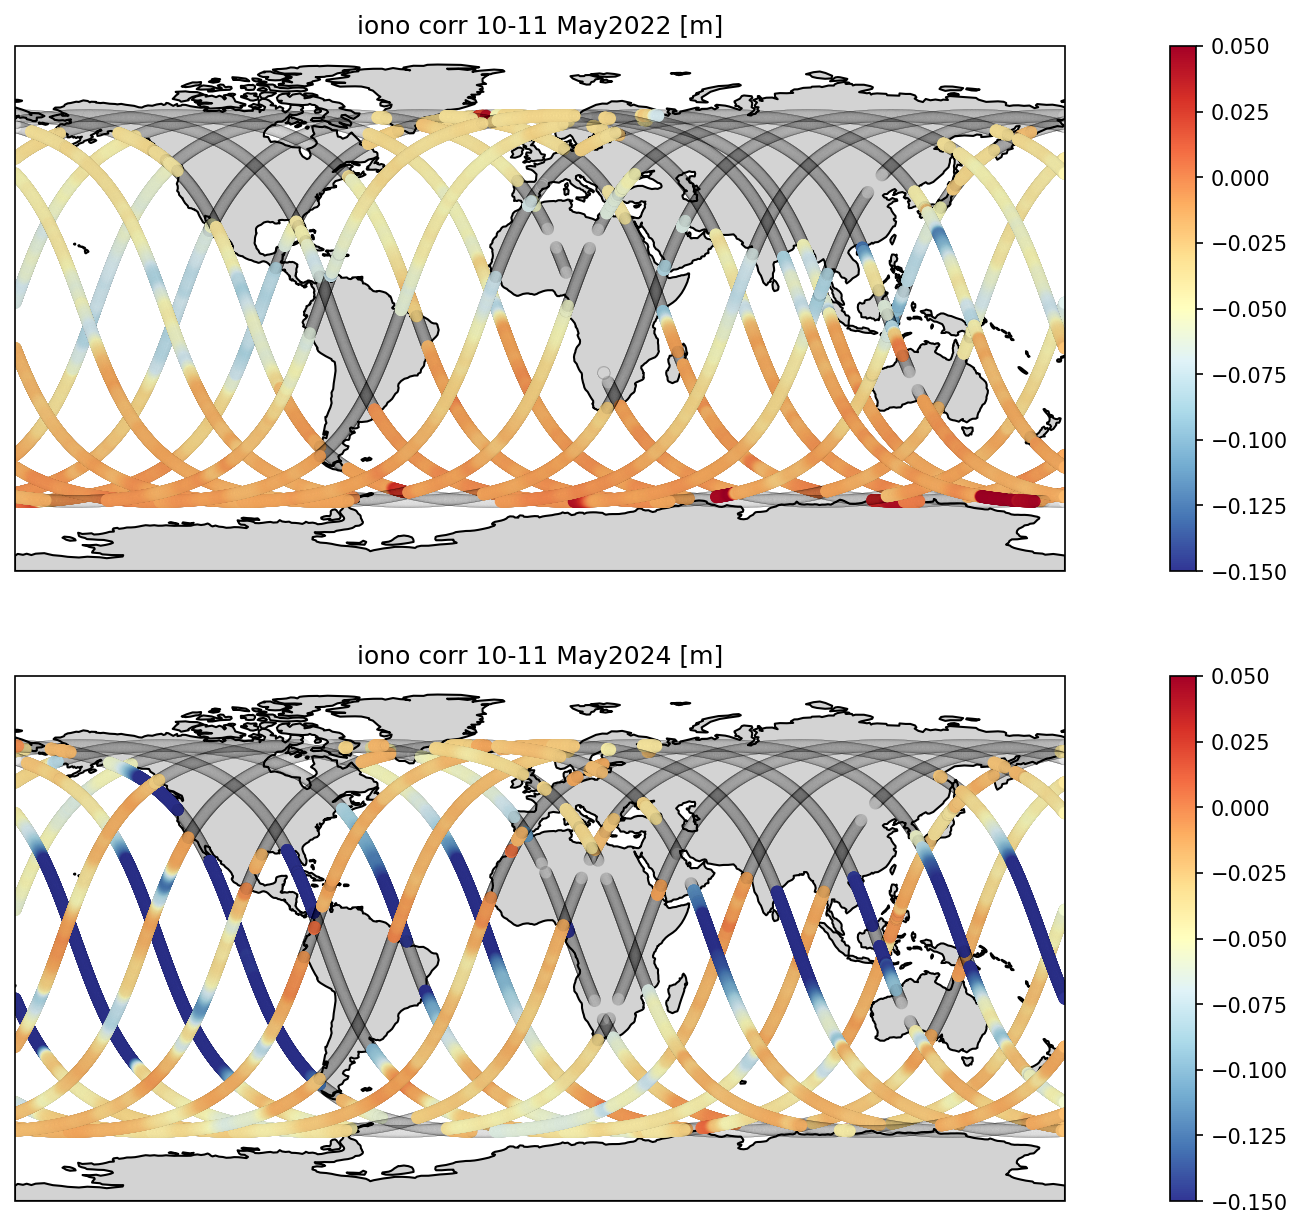

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18, 10), dpi=150, sharex=True, sharey=True, subplot_kw={"projection": ccrs.PlateCarree()})
cmap = plt.cm.RdYlBu_r

for ax, year in zip(axs, years):
    ax.set_extent([-180, 180, -90, 90])
    ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=0)
    trackmap = ax.scatter(S6_vars[year]["longitude"], S6_vars[year]["latitude"], c=S6_vars[year]["iono_cor_alt_filtered"], cmap=cmap, marker='o',\
                          vmin=-0.15, vmax=0.05, edgecolors='black', linewidth=0.01, transform=ccrs.PlateCarree())
    cbar = plt.colorbar(trackmap, ax=ax)
    ax.set_title('iono corr 10-11 May'+str(year)+' [m]', size=12)

plt.show()

We can see that in 2024, all descending tracks have lower values (higher absolute values) than all ascending tracks at least at temperate/tropical latitudes for those dates. There is a slight difference in 2022 between ascending and descending tracks, but much less obvious.

In fact, daylight is important here, and descending tracks will be at the opposite of the diurnal phase than their ascending counterparts. Said otherwise, if the Sun is shining on the side of the Earth where the satellite is descending, it is night on the other side where it is ascending (or vice-versa at other dates). There are a bit more than 24 tracks a day (27) but not much, so it roughly means that during one single day all descending passes will more or less be under daylight, or all ascending (it shifts over time)<br>
We will use the formula " solar_local_time = UTC_time + longitude / 15 " (very, very, rough computation - more a "solar time zone" than solar time proper, but it is sufficient here to pinpoint whether it is day - or night - for a given track, at the Equator)

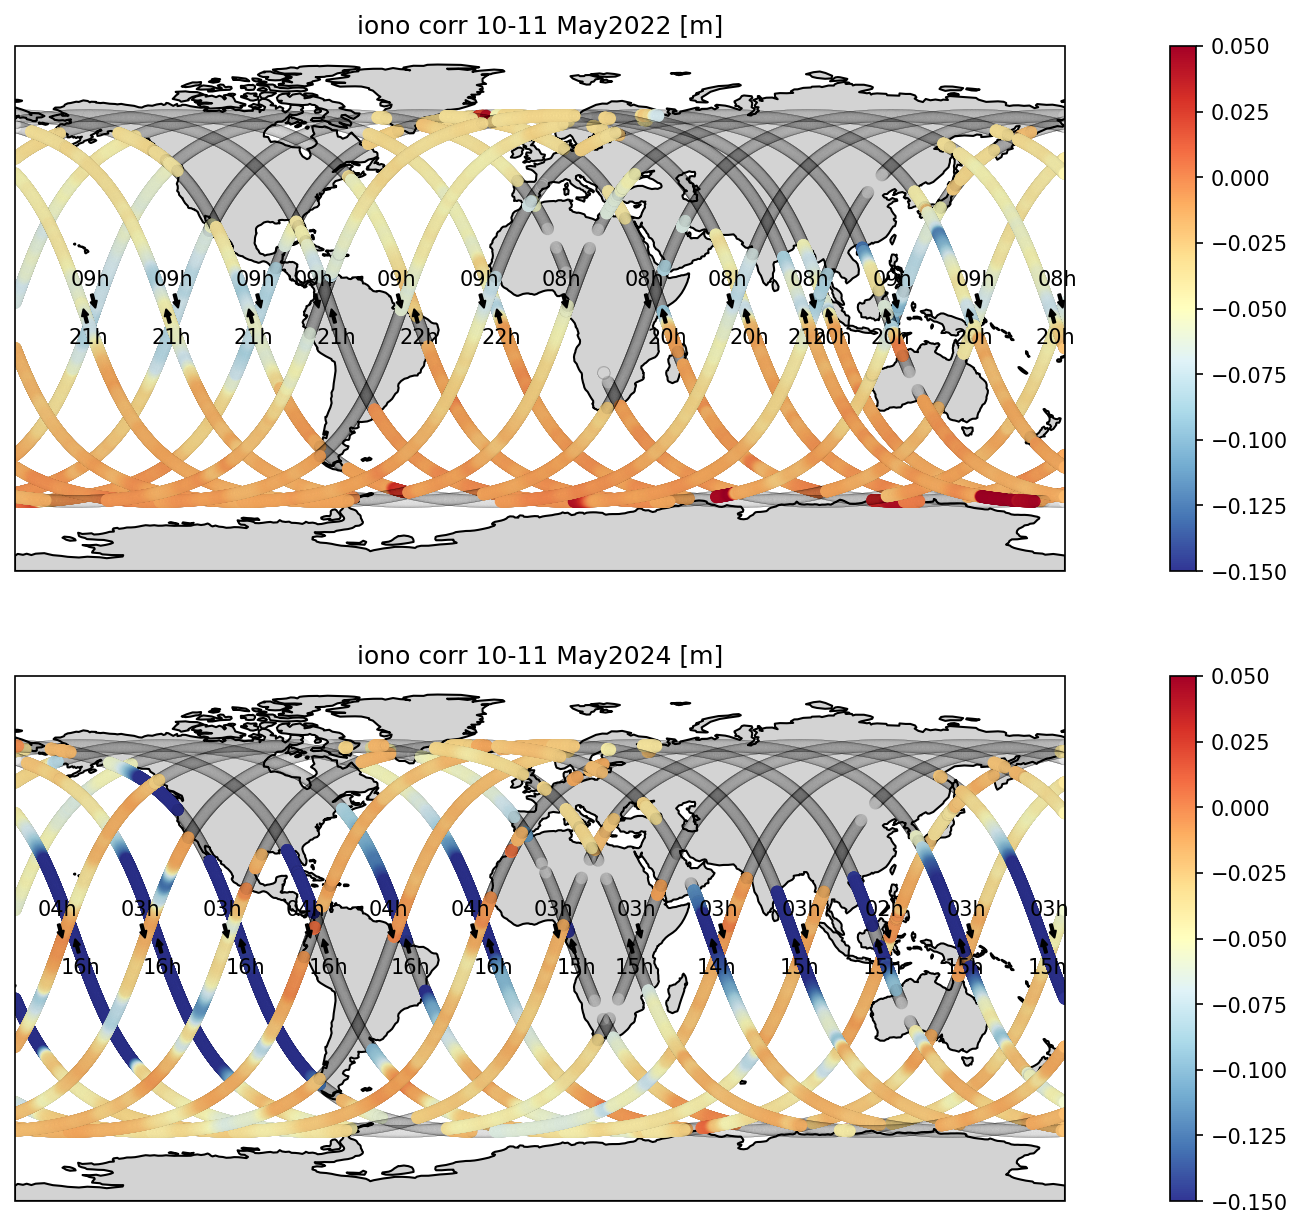

In [11]:
# no measurement will be precisely at the Equator (latitude == 0), so we use an "epsilon" to define the unique point in each track closest to the Equator. 
dlat = 0.05 # approximate step in latitude between two 1Hz measurements at the Equator
dlon = -0.0175 # approximate step in longitude between two 1Hz measurements at the Equator 

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18, 10), dpi=150, sharex=True, sharey=True, subplot_kw={"projection": ccrs.PlateCarree()})
cmap = plt.cm.RdYlBu_r

for ax, year in zip(axs, years):
    # Compute local solar time zone around lat 0 - condition used to select this point
    closest_pt_Eq = (S6_vars[year]["latitude"] > 0-dlat/2) & (S6_vars[year]["latitude"] < 0+dlat/2)
    
    # define the longitude (-180 - 180°) where the track crosses the Equator, to define an approximate solar time zone, and have + or - time lags 
    # with respect to longitude == 0)
    lon_equator = ((((S6_vars[year]["longitude"].sel(time=closest_pt_Eq)) - 180) % 360) - 180 )
    lat_equator = S6_vars[year]["latitude"].sel(time=closest_pt_Eq).values
    utc_time_equator = S6_vars[year]["time"].sel(time=closest_pt_Eq)

    # 360° divided by 24 hours makes approximate 15° in longitude time-zones (not legal time zone, though)
    solar_time_equator = utc_time_equator + (lon_equator/15).astype('timedelta64[h]')

    ax.set_extent([-180, 180, -90, 90])
    ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=0)
    trackmap = ax.scatter(S6_vars[year]["longitude"], S6_vars[year]["latitude"], c=S6_vars[year]["iono_cor_alt_filtered"], cmap=cmap, marker='o',\
                          vmin=-0.15, vmax=0.05, edgecolors='black', linewidth=0.01, transform=ccrs.PlateCarree())

    # annotate with solar_time_equator (hour only) at lattext,lontext
    # we will shift texts one side or the other, depending on each track direction, using the appropriate flag
    passdir = ((S6_vars[year]["pass_direction_flag"].sel(time=closest_pt_Eq).values)) - 0.5
    passsign = np.sign(passdir) # descending tracks will be negative, ascending positive
    
    #define latitude to print the hour; delta is purely empirical
    lattext = lat_equator + 200*dlat*passsign
    #define longitude to print the hour; delta is purely empirical
    lontext = lon_equator + 100*dlon*passsign
    
    for i in range(0,len(lontext)):
        localsolarhour = str(solar_time_equator[i].values)[11:13] + 'h'
        #ax.plot(long_equator2024[i], lat_equator2024[i], marker='o', color='black',  markersize=15)
        ax.annotate(localsolarhour, xy=(lon_equator[i], lat_equator[i]), xytext=(lontext[i], lattext[i]), 
                arrowprops=dict(
                    facecolor='black', # color of arrow
                    shrink=0.05, # distance from point
                    width=1, # width of arrow
                    headwidth=3, # width of arrow head
                    headlength=3 # length of arrow head
                ), verticalalignment='center', horizontalalignment='center')

    cbar = plt.colorbar(trackmap, ax=ax)
    ax.set_title('iono corr 10-11 May'+str(year)+' [m]', size=12)

plt.show()

<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Statistical comparisons
[Back to top](#TOC_TOP)

</div>

Some statistics

In [12]:
for year in years:
    print(year)
    print(' min: ', round(np.nanmin(S6_vars[year]["iono_cor_alt_filtered"].values), 2))
    print(' mean', round(np.nanmean(S6_vars[year]["iono_cor_alt_filtered"].values), 2))
    print(' std:', round(np.nanstd(S6_vars[year]["iono_cor_alt_filtered"].values), 2))

2022
 min:  -0.13
 mean -0.03
 std: 0.02
2024
 min:  -0.45
 mean -0.07
 std: 0.07


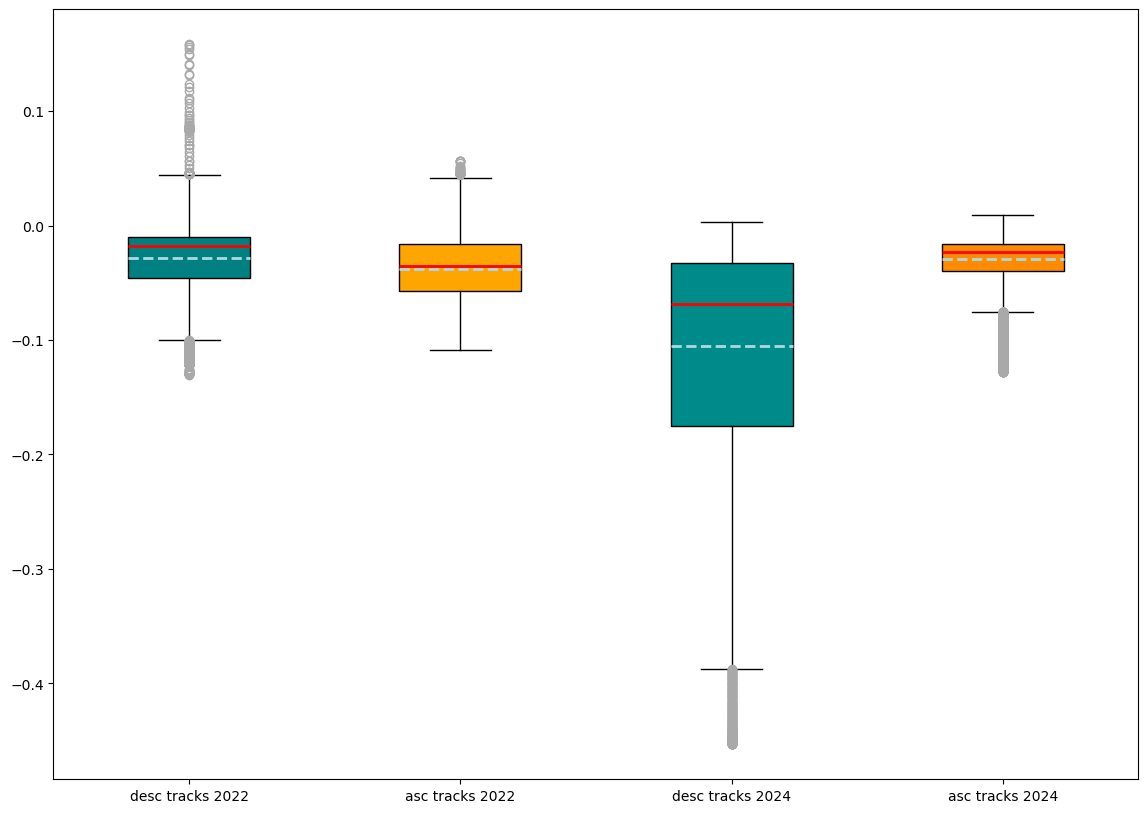

In [13]:
fig, ax = plt.subplots( figsize=(14, 10))

desc_tracks_iono_2022 = S6_vars[2022]["iono_cor_alt_filtered"].sel(time=(S6_vars[2022]["pass_direction_flag"]==0)).dropna(dim="time", how="any")
asc_tracks_iono_2022 = S6_vars[2022]["iono_cor_alt_filtered"].sel(time=(S6_vars[2022]["pass_direction_flag"]==1)).dropna(dim="time", how="any")
desc_tracks_iono_2024 = S6_vars[2024]["iono_cor_alt_filtered"].sel(time=(S6_vars[2024]["pass_direction_flag"]==0)).dropna(dim="time", how="any")
asc_tracks_iono_2024 = S6_vars[2024]["iono_cor_alt_filtered"].sel(time=(S6_vars[2024]["pass_direction_flag"]==1)).dropna(dim="time", how="any")

data = [desc_tracks_iono_2022, asc_tracks_iono_2022, desc_tracks_iono_2024, asc_tracks_iono_2024]
labels = ['desc tracks 2022', 'asc tracks 2022', 'desc tracks 2024', 'asc tracks 2024']
colors = ['teal', 'orange', 'darkcyan', 'darkorange']

# Creates a boxplot showfliers=False, 
bplot= plt.boxplot(data, medianprops={'linewidth': 2, 'color': 'red'}, patch_artist=True, tick_labels=labels, flierprops={'markeredgecolor': 'darkgrey'}, \
                   showmeans=True, meanline=True, meanprops={'linestyle': '--', 'linewidth': 2, 'color': 'lightblue'})

# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.show()

https://www.aviso.altimetry.fr/fileadmin/documents/data/tools/NT-Nencioli_FilteredIonosphericCorrection.pdf

The dual-frequency ionospheric correction is directly proportional to the ionospheric TEC which is primarily controlled by solar radiation. Thus, the spatial distribution and temporal variability of the correction are function of three main factors:<br>
• Solar activity: values of the correction increase during periods of stronger solar activity<br>
• Local time: absolute values of the correction are higher during local day times (maximum values around local 14:00) and lower during local night times (minimum values around local 2:00)<br>
• Latitudinal location: correction values are highest within the tropics (maxima at around ±15◦ of latitude) and smallest at high latitudes<br>

<hr>
<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./2_3_S6_coastal_waveforms.ipynb" target="_blank"><< Coastal waveforms</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./2_5_acquire_S6_available_cycles.ipynb">Acquire a Sentinel-6 track over all available cycles >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>